In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/T2I_CL/DM-GAN+CL/code

Mounted at /content/gdrive
/content/gdrive/MyDrive/T2I_CL/DM-GAN+CL/code


In [2]:
import os
import pickle
import numpy as np
import torch
from PIL import Image
from nltk.tokenize import RegexpTokenizer

from miscc.config import cfg, cfg_from_file
from model import RNN_ENCODER, G_NET


class DM_GAN:

  def __init__(self, cfg_file="cfg/eval_coco.yml"):
    
    cfg_from_file(cfg_file)
    self.batch_size = 1
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    with open("../data/coco/captions.pickle", "rb") as f:
      self.wordtoix = pickle.load(f)[3]
    self.tokenizer = RegexpTokenizer(r'\w+')
    
    self.text_encoder = RNN_ENCODER(len(self.wordtoix), nhidden=cfg.TEXT.EMBEDDING_DIM)
    self.text_encoder.load_state_dict(torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage))
    print('Load text encoder from:', cfg.TRAIN.NET_E)
    self.netG = G_NET()
    self.netG.load_state_dict(torch.load(cfg.TRAIN.NET_G, map_location=lambda storage, loc: storage))
    print('Load G from: ', cfg.TRAIN.NET_G)

    self.text_encoder = self.text_encoder.to(self.device)
    self.netG = self.netG.to(self.device)

  def text2img(self, sentence):
    
    self.text_encoder.eval()
    self.netG.eval()

    tokens = self.tokenizer.tokenize(sentence.lower())
    captions = torch.from_numpy(np.array([[self.wordtoix[token] for token in tokens]])).to(self.device)
    cap_lens = torch.from_numpy(np.array([len(tokens)])).to(self.device)
    noise = torch.FloatTensor(self.batch_size, cfg.GAN.Z_DIM).to(self.device)

    with torch.no_grad():
      hidden = self.text_encoder.init_hidden(self.batch_size)
      words_embs, sent_emb = self.text_encoder(captions, cap_lens, hidden)
      mask = (captions == 0)
      noise.data.normal_(0, 1)
      fake_imgs, attention_maps, _, _ = self.netG(noise, sent_emb, words_embs, mask, cap_lens)

    return fake_imgs[-1][0].data.cpu().numpy()


def show_img(img):
  
  img = (img + 1.0) * 127.5
  img = img.astype(np.uint8)
  img = np.transpose(img,(1,2,0))
  img = Image.fromarray(img)
  display(img)


def save_img(img, save_path="../output/example_001.png"):

  img = (img + 1.0) * 127.5
  img = img.astype(np.uint8)
  img = np.transpose(img,(1,2,0))
  img = Image.fromarray(img)
  print(f'Image is saved to "{save_path}"')
  img.save(save_path)

In [3]:
example = "A bunch of various vegetables on a table."

model = DM_GAN()
img = model.text2img(example)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Load text encoder from: ../DAMSMencoders/coco/text_encoder100.pth
Load G from:  ../models/netG_epoch_200.pth


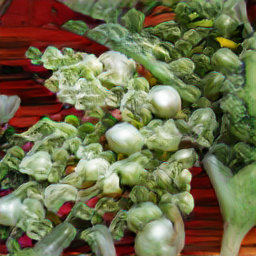

In [4]:
show_img(img)

In [5]:
path = "../output/example_001.png"
save_img(img,path)

Image is saved to "../output/example_001.png"
